In [1]:
import os
import jax
import jax.numpy as jnp
from jax import vmap
import flax.linen as nn
import numpy as np
import pandas as pd
import yaml
from datetime import datetime
from flax.training import train_state
import optax
from model import ConfigurableModel
from tqdm import tqdm
import pickle
import json
import csv
from Helper import *
from Image import *
from Psi import *
from Optimize import *
import matplotlib.pyplot as plt

2025-06-30 16:06:42.850349: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
2025-06-30 16:06:42.936157: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


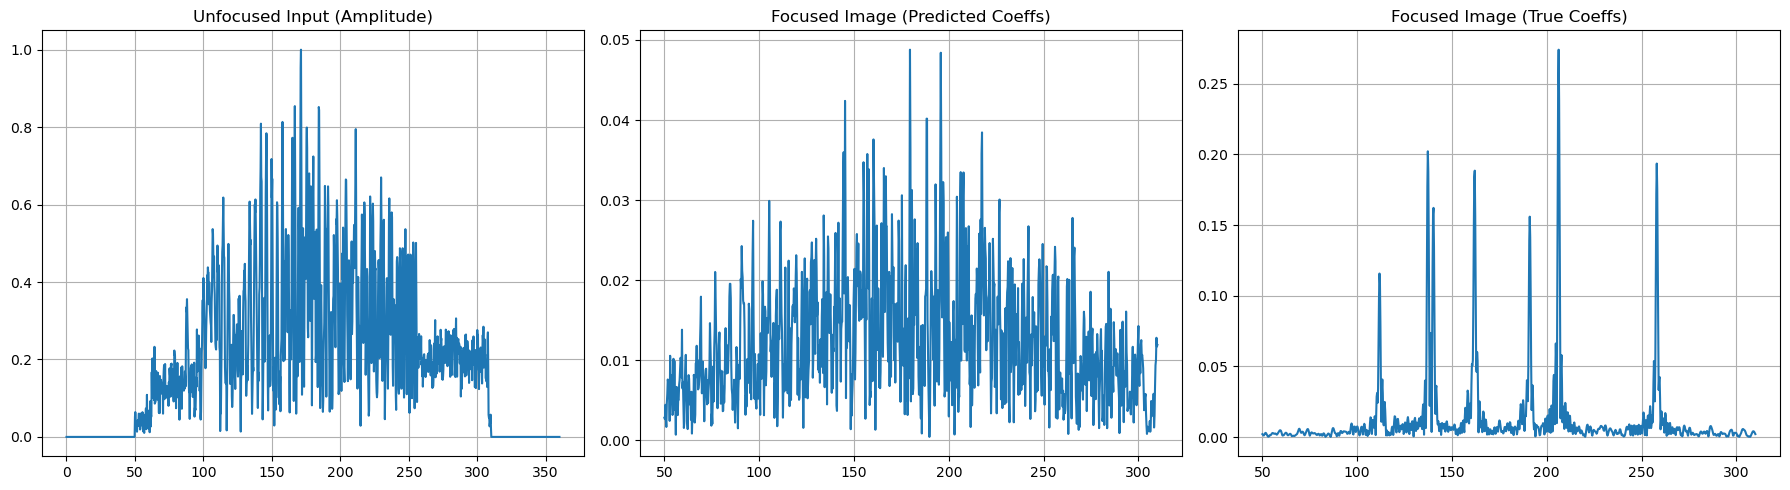

In [9]:

# --- Setup ---
os.environ["JAX_TRACEBACK_FILTERING"] = "off"
with open("config_simple.yaml", "r") as f:
    config = yaml.safe_load(f)

cached_weights_path = "/home/houtlaw/iono-net/model/model_weights_full_20250630_161431.pkl"
sample_idx = 0  # which test sample to visualize

# --- Model Setup ---
architecture = config['model']['architecture']
activation_fn = getattr(jnp, config['model']['activation'])
model = ConfigurableModel(architecture=architecture, activation_fn=activation_fn)
variables = model.init(jax.random.PRNGKey(0), jnp.ones((1, 2882)), deterministic=True)

with open(cached_weights_path, "rb") as f:
    params = pickle.load(f)
model_params = params


# --- Utility Functions ---
def convert_to_complex(s):
    if s == "NaNNaNi":
        return 0
    return complex(s.replace('i', 'j'))

def normalize_complex_to_unit_range(matrix):
    amp = np.abs(matrix)
    amp_max = np.max(amp, axis=1, keepdims=True)
    amp_max[amp_max == 0] = 1
    return matrix / amp_max

def split_complex_to_imaginary(complex_array):
    return np.concatenate([complex_array.real, complex_array.imag], axis=-1)

def unsplit_real_imag(array):
    half = array.shape[-1] // 2
    return array[..., :half] + 1j * array[..., half:]

# --- Load Test Data ---
label_path = config['paths']['test_label_file_path']
signal_path = config['paths']['test_data_file_path']
x_range_path = config['paths']['x_range_file_path']
setup_path = config['paths']['setup_file_path']
kpsi_path = config['paths']['kpsi_file_path']

label_df = pd.read_csv(label_path, dtype=str)
signal_df = pd.read_csv(signal_path, dtype=str)

label_matrix = normalize_complex_to_unit_range(label_df.map(convert_to_complex).to_numpy().T)
signal_matrix = normalize_complex_to_unit_range(signal_df.map(convert_to_complex).to_numpy().T)

x_range = pd.read_csv(x_range_path).iloc[:, 0].values
kpsi_values = pd.read_csv(kpsi_path).values.flatten()

with open(setup_path) as f:
    setup = json.load(f)

F, ionoNHarm, xi = setup["F"], setup["ionoNharm"], setup["xi"]
dx = 0.25
zero_pad = 50

# --- Select Sample ---
signal_complex = signal_matrix[sample_idx]
true_coeffs_complex = label_matrix[sample_idx]

signal_input = split_complex_to_imaginary(signal_complex)[None, :]  # shape (1, 2882)

# --- Inference ---
pred = model.apply({'params': model_params}, signal_input, deterministic=True)
pred_real, pred_imag = pred[0, :6], pred[0, 6:]
true_real, true_imag = true_coeffs_complex.real[:6], true_coeffs_complex.imag[:6]

# --- Construct Images ---
def interference_integral(signal_complex, coeffs_real, coeffs_imag):
    x_trim = x_range[4 * zero_pad : -4 * zero_pad]
    signal_trim = signal_complex[4 * zero_pad : -4 * zero_pad]
    window_size = int(F / dx) + 1
    offsets = jnp.linspace(-F / 2, F / 2, window_size)

    def eval_point(y):
        base = y + offsets
        sarr = xi * base + (1 - xi) * y
        waveform = jnp.exp(-1j * jnp.pi * (base - y)**2 / F)
        psi_phase = jnp.sum(coeffs_real[:, None] * jnp.cos(jnp.outer(sarr, kpsi_values).T), axis=0) \
                  - jnp.sum(coeffs_imag[:, None] * jnp.sin(jnp.outer(sarr, kpsi_values).T), axis=0)
        psi_vals = jnp.exp(1j * psi_phase)
        interp_re = jnp.interp(base, x_trim, jnp.real(signal_trim))
        interp_im = jnp.interp(base, x_trim, jnp.imag(signal_trim))
        integrand = (interp_re + 1j * interp_im) * waveform * psi_vals
        return jnp.trapezoid(integrand, dx=dx) / F

    return vmap(eval_point)(x_trim)

signal_trimmed = signal_complex
image_pred = interference_integral(signal_trimmed, pred_real, pred_imag)
image_true = interference_integral(signal_trimmed, true_real, true_imag)

# --- Plot ---
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Unfocused Input (Amplitude)")
plt.plot(x_range, np.abs(signal_trimmed))
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Focused Image (Predicted Coeffs)")
plt.plot(x_range[4 * zero_pad : -4 * zero_pad], np.abs(image_pred))
plt.grid()

plt.subplot(1, 3, 3)
plt.title("Focused Image (True Coeffs)")
plt.plot(x_range[4 * zero_pad : -4 * zero_pad], np.abs(image_true))
plt.grid()

plt.tight_layout()
plt.show()
